# Plot the evolutionary dynamics in a 2-Simplex

In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
import egttools as egt

In [15]:
from egttools.plotting.helpers import (xy_to_barycentric_coordinates, 
                                       barycentric_to_xy_coordinates,
                                       find_roots_in_discrete_barycentric_coordinates,
                                       calculate_stability, 
                                    )
from egttools.analytical.utils import (find_roots, check_replicator_stability_pairwise_games, )
from egttools.helpers.vectorized import vectorized_replicator_equation, vectorized_barycentric_to_xy_coordinates

## Evolutionary dynamics in infinite populations

In infinite populations the dynamics are given by the replicator equation. Following we calculate the gradients for all the points in a grid and plot them in a 2-simplex using the Simplex2D class.

We will also be plotting in the simplex the stationary points. We will use black circle to represent stable equilibrium and white circles to represent unstable ones. The arrows indicate the direction of the selective pressure.

### Calculate gradients

\left(
\begin{array}{ccc}
 R & R & S \\
 R & R & \delta  \text{PU}+(1-\delta ) S \\
 T & \delta  \text{PU}+(1-\delta ) T & \text{PU} \\
\end{array}
\right);

In [16]:
R = 3
S = 0
P = 1
T= 4
delta = 0.9

In [17]:
payoffs = np.array([[R, R, S],
                    [R, R, delta*P+(1-delta)*S],
                    [T, delta*P +(1-delta)*T, P]])

In [18]:
simplex = egt.plotting.Simplex2D()

In [19]:
v = np.asarray(xy_to_barycentric_coordinates(simplex.X, simplex.Y, simplex.corners))

In [20]:
results = vectorized_replicator_equation(v, payoffs)
xy_results = vectorized_barycentric_to_xy_coordinates(results, simplex.corners)
Ux = xy_results[:, :, 0].astype(np.float64)
Uy = xy_results[:, :, 1].astype(np.float64)                                            

In [21]:
calculate_gradients = lambda u: egt.analytical.replicator_equation(u, payoffs)

roots = find_roots(gradient_function=calculate_gradients,
                   nb_strategies=payoffs.shape[0],
                   nb_initial_random_points=15)


In [22]:
roots

[array([1., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([8.13527538e-02, 9.18647246e-01, 1.08235964e-17]),
 array([4.45250929e-01, 5.54749070e-01, 1.63085208e-10]),
 array([5.73951509e-01, 4.26048491e-01, 1.10378183e-11]),
 array([4.67859652e-02, 9.53214035e-01, 1.87706877e-13]),
 array([9.02643446e-01, 9.73565538e-02, 2.06185637e-14]),
 array([ 1.41434774e-01,  8.58565226e-01, -3.13894087e-14]),
 array([4.77531589e-01, 5.22468411e-01, 3.03370472e-13]),
 array([ 9.23003015e-01,  7.69969853e-02, -8.21783525e-14]),
 array([-1.53760462e-13,  5.55555556e-02,  9.44444444e-01]),
 array([4.59741211e-01, 5.40258789e-01, 8.86430279e-11]),
 array([ 7.89754646e-01,  2.10245354e-01, -8.09005995e-15]),
 array([2.88018818e-01, 7.11981182e-01, 7.24734358e-13]),
 array([ 4.57596530e-01,  5.42403470e-01, -4.19368387e-11]),
 array([ 9.18716265e-01,  8.12837350e-02, -8.13421808e-15])]

In [23]:
#MY BIT
discarded_neutral_roots = []
for vector in roots:
    if sum(vector)== 1 or vector[2] > 0.0001:
        discarded_neutral_roots.append(vector)
discarded_neutral_roots

[array([1., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([8.13527538e-02, 9.18647246e-01, 1.08235964e-17]),
 array([-1.53760462e-13,  5.55555556e-02,  9.44444444e-01])]

In [24]:
roots= discarded_neutral_roots
roots_xy = [barycentric_to_xy_coordinates(root, corners=simplex.corners) for root in roots]

stability = check_replicator_stability_pairwise_games(roots, payoffs)

In [25]:
stability[3] =-1

In [26]:
type_labels = ['ALLC   ', 'TFT', '   ALLD']

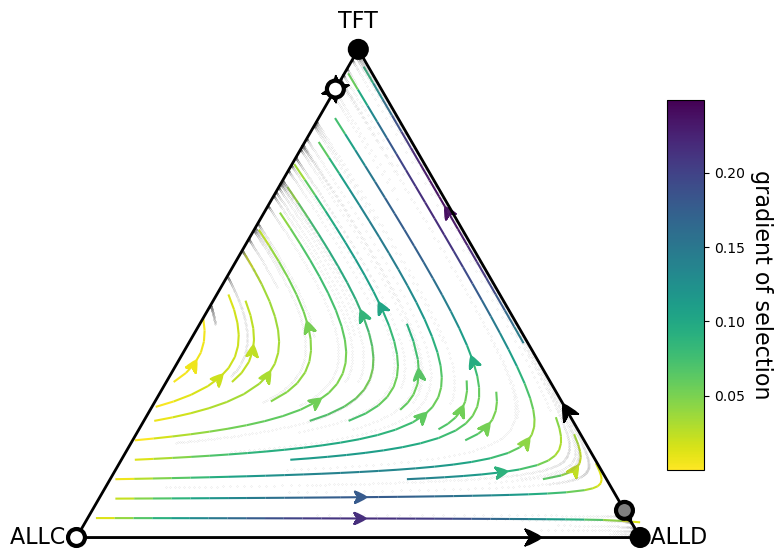

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

plot = (simplex.add_axis(ax=ax)
           .apply_simplex_boundaries_to_gradients(Ux, Uy)
           .draw_triangle()
           .draw_gradients(zorder=0,cmap="viridis_r")
           .add_colorbar()  
           .draw_stationary_points(roots_xy, stability)
           .add_vertex_labels(type_labels)
           .draw_scatter_shadow(lambda u, t: egt.analytical.replicator_equation(u, payoffs),50, color='gray', marker='.', s=0.02)
           .draw_trajectory_from_roots(lambda u, t: egt.analytical.replicator_equation(u, payoffs), 
                                       roots,
                                       stability,
                                       trajectory_length=25,
                                       linewidth=0.5,
                                       step=0.05,
                                       color='k', draw_arrow=True, arrowdirection='right', arrowsize=30, zorder=4, arrowstyle='fancy')
        
          )

ax.axis('off')
ax.set_aspect('equal')

plt.xlim((-.05,1.05))
plt.ylim((-.02, simplex.top_corner + 0.05))
plt.savefig("simplex_deterministic_2.pdf", bbox_inches="tight")

## Finite populations

In finite populations we will model the dynamics using a Moran process. The calculation of the gradients is implemented in EGTtools in the StochDynamics class. In this case, since we want to calculate the gradient at any point in the simplex, we will use the `full_gradient_selection` method

### Calculate gradients

In [28]:
Z = 20
beta = 1.0
mu = 1e-3

In [29]:
simplex = egt.plotting.Simplex2D(discrete=True, size=Z, nb_points=Z+1)

In [30]:
v = np.asarray(xy_to_barycentric_coordinates(simplex.X, simplex.Y, simplex.corners))

In [31]:
v_int = np.floor(v * Z).astype(np.int64)

In [32]:
evolver = egt.analytical.StochDynamics(3, payoffs, Z)

In [33]:
result = np.asarray([[evolver.full_gradient_selection(v_int[:, i, j], beta) for j in range(v_int.shape[2])] for i in range(v_int.shape[1])]).swapaxes(0, 1).swapaxes(0, 2)

In [34]:
xy_results = vectorized_barycentric_to_xy_coordinates(result, simplex.corners)

Ux = xy_results[:, :, 0].astype(np.float64)
Uy = xy_results[:, :, 1].astype(np.float64)

In [35]:
calculate_gradients = lambda u: Z*evolver.full_gradient_selection(u, beta)

roots = find_roots_in_discrete_barycentric_coordinates(calculate_gradients, Z, nb_interior_points=5151, atol=1e-1)
roots

[array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([1., 0., 0.]),
 array([ 8.86792302e-01,  1.20585236e-01, -8.07088621e-16]),
 array([6.71436645e-01, 3.29046973e-01, 2.14138986e-17])]

In [36]:
#MY BIT
discarded_neutral_roots = []
for vector in roots:
    if sum(vector)== 1 or vector[2] > 0.0001:
        discarded_neutral_roots.append(vector)
discarded_neutral_roots

[array([0., 1., 0.]), array([0., 0., 1.]), array([1., 0., 0.])]

In [37]:
roots = discarded_neutral_roots

In [38]:
roots_xy = [barycentric_to_xy_coordinates(x, simplex.corners) for x in roots]

stability = calculate_stability(roots, calculate_gradients)

### Calculate stationary distribution

We can also plot the stationary distribution inside the simplex. It will give us an idea on where our population is going to spend most of the time

In [39]:
evolver.mu = 1e-3
sd = evolver.calculate_stationary_distribution(beta)

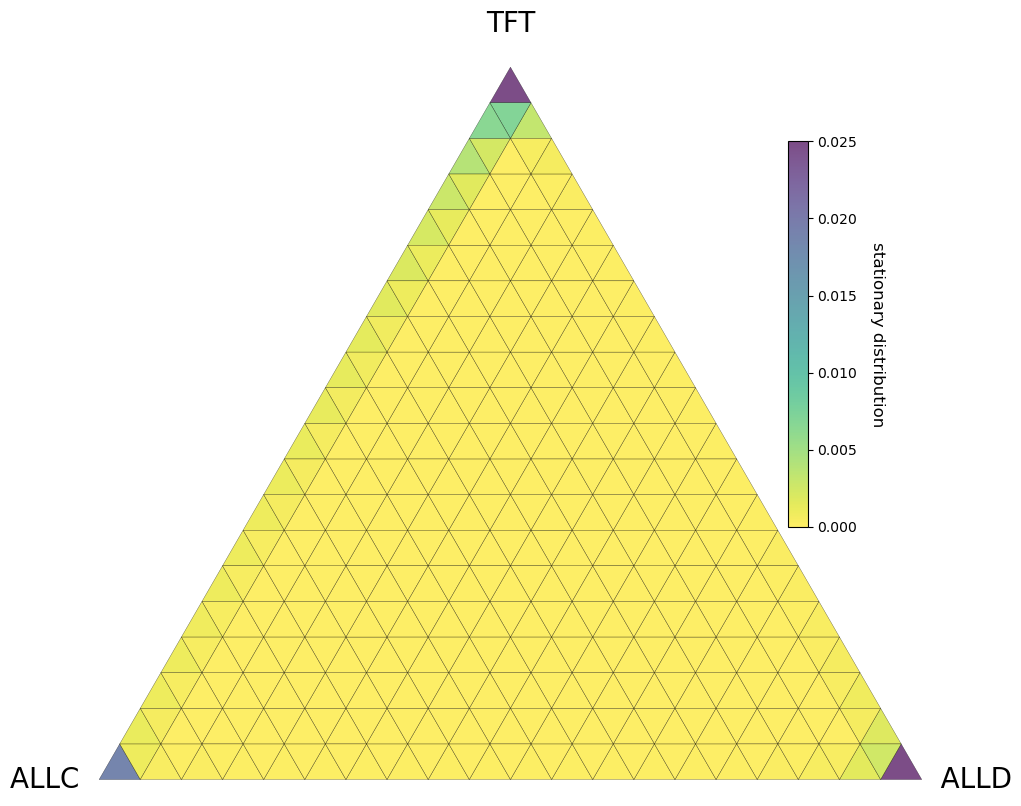

In [41]:
fig, ax = plt.subplots(figsize=(15,10))

plot = (simplex.add_axis(ax=ax)
           .apply_simplex_boundaries_to_gradients(Ux, Uy)
           #.draw_gradients(zorder=2, cmap="viridis")
           #.add_colorbar()
           #.draw_stationary_points(roots_xy, stability, zorder=11)
           .add_vertex_labels(type_labels, fontsize=20)
           .draw_stationary_distribution(sd, vmax=0.025, vmin=0.00, alpha=0.7, edgecolors='black', cmap='viridis_r', shading='flat', zorder=0,
                                        shrink = 0.5, label_rotation=270, label_fontsize=12, labelpad=20, aspect=20, anchor=(-1.5, 0.7), panchor=(-1, 0))
           )

ax.axis('off')
ax.set_aspect('equal')

plt.xlim((-.05,1.05))
plt.ylim((-.02, simplex.top_corner + 0.05))
plt.savefig("simplex_stochastic_3.pdf", bbox_inches="tight")